# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

**План по выполнению проекта**

1. Исследовательский анализ набора фотографий
2. Подготовка данных к обучению
3. Обучение нейронной сети и рассчет её качества

**Описание данных**

- `/datasets/faces/labels.csv`- ссылка на данные 
- Столбец *file_name* - набор фотографий
- Столбец *real_age* — возраст

## Исследовательский анализ данных

### Импорт библиотек

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Загрузка и анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Создаем генератор изображений
datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Создаем поток данных изображений из датафрейма
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [5]:
# Получаем один батч данных (изображения и соответствующие метки)
features, target = next(gen_flow)

In [8]:
#вывод первых пяти строк
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датафрейме отсутствуют пропуски, всего 7591 строк

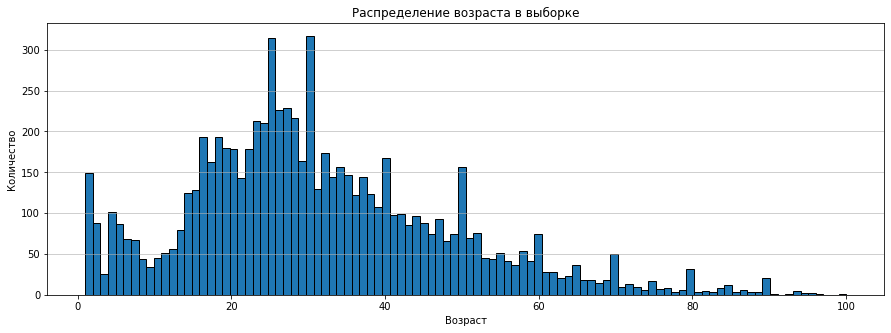

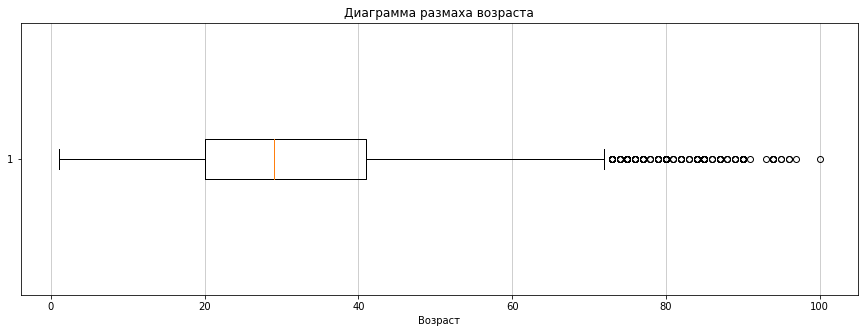

In [13]:
# График распределения возраста в выборке
plt.figure(figsize=(15, 5))
plt.hist(labels['real_age'], bins=100, edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(axis='y', alpha=0.75)

# Диаграмма размаха
plt.figure(figsize=(15, 5))
plt.boxplot(labels['real_age'], vert=False)
plt.title('Диаграмма размаха возраста')
plt.xlabel('Возраст')
plt.grid(axis='x', alpha=0.75)

plt.show()

In [10]:
print(f"Медианный возраст: {labels['real_age'].median()}")
print(f"Средний возраст: {round(labels['real_age'].mean(),2)}")
print(f"Минимальный возраст: {labels['real_age'].min()}")
print(f"Максимальный возраст: {labels['real_age'].max()}")

Медианный возраст: 29.0
Средний возраст: 31.2
Минимальный возраст: 1
Максимальный возраст: 100


In [28]:
# 25-й и 75-й процентили
Q1 = labels['real_age'].quantile(0.25)
Q3 = labels['real_age'].quantile(0.75)

# Расчёт процента верхних выбросов
upper_outliers_percentage = (len(labels['real_age'][labels['real_age'] > (Q3 + 1.5 * (Q3 - Q1))]) /
                             len(labels['real_age'])) * 100


print(f"В основном возраст людей на фотографиях варьируется от {Q1} до {Q3} лет")
print(f"Верхняя граница выбросов: {round(Q3 + 1.5 * (Q3 - Q1),0)} лет и составляет {round(upper_outliers_percentage,1)}%")

В основном возраст людей на фотографиях варьируется от 20.0 до 41.0 лет
Верхняя граница выбросов: 72.0 лет и составляет 2.2%


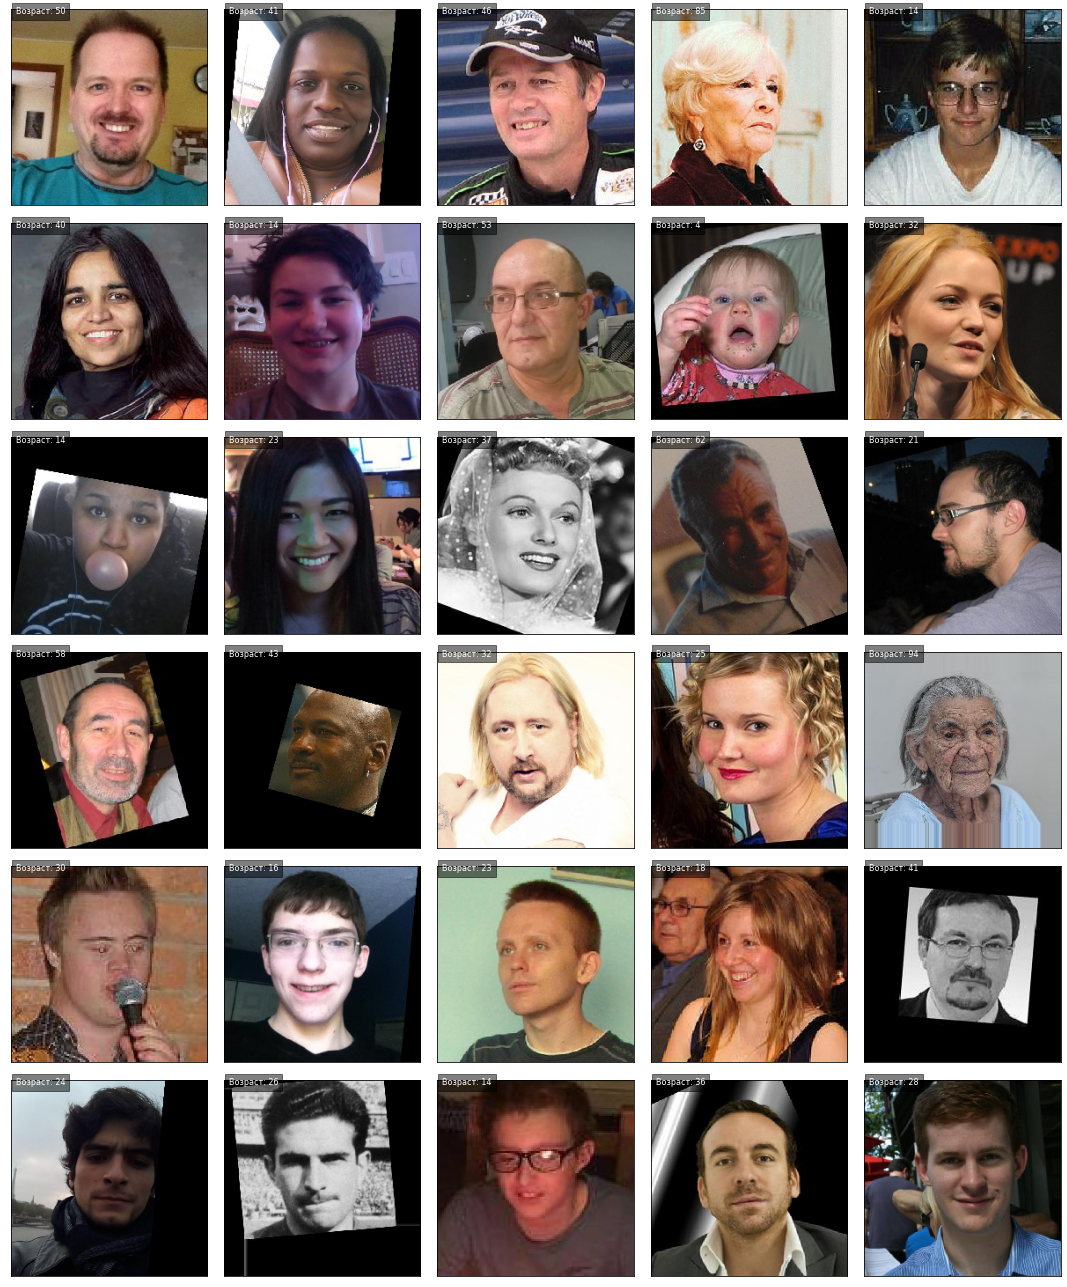

In [31]:
# Выводим 30 изображений
fig = plt.figure(figsize=(15, 18))  
for i in range(30):
    ax = fig.add_subplot(6, 5, i+1)  
    plt.imshow(features[i])
    # Удаление осей
    plt.xticks([])
    plt.yticks([])
    # Добавление возраста на изображение
    plt.text(5, 5, f'Возраст: {target[i]}', color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
plt.tight_layout()
plt.show()

- Размер выборки 7591 строки, пропуски отсутствуют
- Средний возраст 30 лет. 
- В выборке есть люди разных возрастов: от одного года до ста лет
- В основном возраст людей на фотографиях варьируется от 20.0 до 41.0 лет. Процент людей с возрастом старше 72лет составляет всего 2.2%.

В датасете представлены фотографии различной четкости, включая цветные и черно-белые изображения. Люди запечатлены в разнообразных локациях: на фоне могут присутствовать другие люди, пейзажи, элементы интерьера. Хотя многие фотографии выровнены, встречаются также повёрнутые или неровно обрезанные изображения с рамкой на черном фоне.

При использовании данных фотографий, для улучшения модели, можно применить различные методы аугментации данных. Это поможет модели лучше обобщать и быть устойчивой к разнообразным входным данным. 

Например, такие методы аугментации, как:

1. Регулировка яркости и контраста.
2. Повороты и отражения.
3. Масштабирование и обрезка.
4. Добавление шума.
5. Изменение цветового пространства.
6. Перспективные трансформации.

## Обучение модели

Используется модель глубокого обучения на основе архитектуры ResNet50. Процесс разделен на несколько функций:

1. **load_train(path)** - Функция загрузки и предобработки тренировочных данных. 
   - Входные данные: путь к данным.
   - Выходные данные: генератор данных для обучения.
   
   В качестве аугментации взято отражение изображений по горизонтали.

2. **load_test(path)** - Функция загрузки и предобработки тестовых данных.
   - Входные данные: путь к данным.
   - Выходные данные: генератор данных для тестирования.
   
   Основой модели служит ResNet50, взятая с предобученными на ImageNet весами для ускорения процесса обучения.
   
   После следует слой GlobalAveragePooling2D. Данный слой уменьшает размерность выходных данных сети, суммируя признаки по пространственным измерениям. Это делает модель менее чувствительной к точному расположению объектов на изображении и уменьшает количество параметров. 
   
   Дальше выходной полносвязный слой с одним нейроном и линейной активацией. 
   
   Используется оптимизатор Adam. 
   
   В качестве функции потерь используется MSE.

3. **create_model(input_shape)** - Функция создания модели глубокого обучения на основе ResNet50.
   - Входные данные: форма входных данных.
   - Выходные данные: скомпилированная модель.

4. **train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)** - Функция обучения модели.
   - Входные данные: модель, тренировочные данные, тестовые данные и параметры обучения. Эпох 20. 
   - Выходные данные: обученная модель.

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python
# Импорт библиотек
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Функция для загрузки и предобработки тренировочных данных
def load_train(path):
    df = pd.read_csv('/datasets/faces/labels.csv')

    datagen = ImageDataGenerator(
        # Нормализация изображений
        rescale=1./255,
        validation_split=0.3,
        # Аугментация: отражение изображений по горизонтали
        horizontal_flip=True)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training'
    )

    return train_datagen_flow

def load_test(path):
    df = pd.read_csv('/datasets/faces/labels.csv')

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.3)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation'
    )

    return test_datagen_flow

# Функция создания модели на основе ResNet50
def create_model(input_shape):
    model = Sequential()
    model.add(ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    ))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

# Функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        verbose=2,
        callbacks=[early_stopping]
    )

    return model

```

**Результат вывода на экран:**
```

Train for 167 steps, validate for 72 steps
Epoch 1/20
2024-07-08 20:22:09.951037: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-08 20:22:10.421699: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
Epoch 2/20
167/167 - 68s - loss: 245.3310 - mae: 11.1472 - val_loss: 792.5184 - val_mae: 23.3681
167/167 - 58s - loss: 78.8717 - mae: 6.6791 - val_loss: 794.4476 - val_mae: 23.4004
Epoch 3/20
167/167 - 55s - loss: 52.3028 - mae: 5.4557 - val_loss: 640.3945 - val_mae: 20.4992
Epoch 4/20
167/167 - 58s - loss: 39.6973 - mae: 4.7343 - val_loss: 141.3610 - val_mae: 9.0779
Epoch 5/20
167/167 - 54s - loss: 31.8868 - mae: 4.2259 - val_loss: 108.8797 - val_mae: 7.8114
Epoch 6/20
167/167 - 58s - loss: 23.5557 - mae: 3.6631 - val_loss: 71.7119 - val_mae: 6.2807
Epoch 7/20
167/167 - 54s - loss: 17.9866 - mae: 3.1796 - val_loss: 68.6944 - val_mae: 6.1564
Epoch 8/20
167/167 - 57s - loss: 15.4236 - mae: 3.0213 - val_loss: 89.2216 - val_mae: 7.4582
Epoch 9/20
167/167 - 54s - loss: 12.5880 - mae: 2.6984 - val_loss: 79.5618 - val_mae: 6.8774
Epoch 10/20
167/167 - 57s - loss: 10.9310 - mae: 2.4871 - val_loss: 72.4325 - val_mae: 6.3538
Epoch 11/20
167/167 - 53s - loss: 10.3484 - mae: 2.3948 - val_loss: 71.5008 - val_mae: 6.2151
Epoch 12/20
167/167 - 57s - loss: 9.1605 - mae: 2.2827 - val_loss: 64.8152 - val_mae: 6.1269
Epoch 13/20
167/167 - 53s - loss: 8.1548 - mae: 2.1758 - val_loss: 66.6041 - val_mae: 6.2274
Epoch 14/20
167/167 - 58s - loss: 7.3482 - mae: 2.0675 - val_loss: 60.8877 - val_mae: 5.7795
Epoch 15/20
167/167 - 51s - loss: 7.6346 - mae: 2.0805 - val_loss: 65.9176 - val_mae: 6.0794
Epoch 16/20
167/167 - 47s - loss: 7.3508 - mae: 2.0226 - val_loss: 78.8007 - val_mae: 6.5717
Epoch 17/20
167/167 - 51s - loss: 6.8870 - mae: 1.9689 - val_loss: 63.5166 - val_mae: 6.0654
Epoch 18/20
167/167 - 56s - loss: 6.8373 - mae: 1.9828 - val_loss: 69.7362 - val_mae: 6.3304
Epoch 19/20
167/167 - 52s - loss: 7.6692 - mae: 2.0693 - val_loss: 66.8126 - val_mae: 6.0882
Epoch 20/20
167/167 - 58s - loss: 7.5338 - mae: 2.0495 - val_loss: 64.8476 - val_mae: 6.0471
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
72/72 - 15s - loss: 64.8476 - mae: 6.0471
Test MAE: 6.0471

```

## Анализ обученной модели

Данный проект по преодобработке фотографий для анализа возраста покупателей включает в себя более 7,5 тысячи данных: 
- Средний возраст 30 лет. 
- В выборке есть люди разных возрастов: от одного года до ста лет
- В основном возраст людей на фотографиях варьируется от 20.0 до 41.0 лет

Модель построена на основе ResNet50 с предобученными весами ImageNet. Включен слой GlobalAveragePooling2D для сокращения размерности и уменьшения чувствительности к расположению объектов. Выходной слой — полносвязный с одним нейроном и линейной активацией. Используется оптимизатор Adam (learning_rate=0.0001) и функция потерь MSE.

1. Начальные потери на тренировочных данных снизились с 245.3310 до 7.5338 через 20 эпох, валидационные - с 792.5184 до 64.8476.

2. Точность предсказаний: MAE на тренировочных данных сократилась  11.1472 до 2.0495 через 20 эпох, валидационные - с 23.3681 до 6.0471.

3. В последних эпохах наблюдается стабилизация потерь и MAE.

4. На тестовых данных MAE составила 6.0471.